In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors

import glob
import gc
import warnings
import copy
import pathlib
import pickle

import os
import shutil

from scipy import stats
import signac
import freud
import gsd.hoomd
import hoomd
import schmeud
import schmeud._schmeud as schmeud_rs
from schmeud._schmeud import statics
from schmeud._schmeud import locality
from schmeud import ml
from tqdm import tqdm

from dataclasses import dataclass
from collections import defaultdict

from numba import njit

In [2]:
from monk import nb, prep, pair, render, utils, workflow, grid

parent = pathlib.Path(os.getcwd()).parent / "config.yaml"
config = workflow.get_config(parent.as_posix())
parent, config

(PosixPath('/home/ian/Projects/work/monk/workflows/2d-osc-shear/config.yaml'),
 {'root': '/media/ian/Data2/monk/2d-osc-shear',
  'origin': '/media/ian/Data2/monk/2d-esl'})

In [3]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'avail_seed': 18, 'dt': 0.005, 'step_unit': 200, 'equil_time': 100, 'min_periods': 20, 'dumps': 40, 'period_times': [30.0, 100.0, 300.0, 1000.0], 'max_shears': [0.01, 0.02, 0.03, 0.05, 0.08, 0.12], '_status': {}}

In [4]:
@dataclass(frozen=True, eq=True)
class Statepoint:
    max_shear: float
    period: float
    temp: float
    prep: str

In [5]:
# let's look at the softess distributions when normalized

In [6]:
output = defaultdict(list)

for job in project:
    print(job)
    prep = job.sp["prep"]
    # if prep != "ESL":
    #     continue
    # print(prep)
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/strob-softness_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 5e-3:
            continue

        if job.isfile(df_path):
            dataset = pl.read_parquet(job.fn(df_path), use_pyarrow=True)
        else:
            continue

        for frame, _, soft in dataset.rows()[-1:]:
            soft = np.array(soft)
            soft = (soft - soft.mean()) / soft.std()
        
        output[sp].append(soft)

634e14bc75836df75158fb15f379d8bb
7ec2f6aca035e69077eab24383a21cb6
cfa1e4c0007fd65d020f809715a6f0b4
ecce68c50e28a33684826f28780bf6e9
1d0fe2ba44a6f635f5504dcbcee0ebc9
1083a2a09eec2c6cf215ebc7a9706cac
09d3dccc56f1fa9330b57901cd232ab7


KeyboardInterrupt: 

/tmp/ipykernel_2128204/1471736462.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("viridis")


Text(0.5, 0, 'softness (normalized by mean and std)')

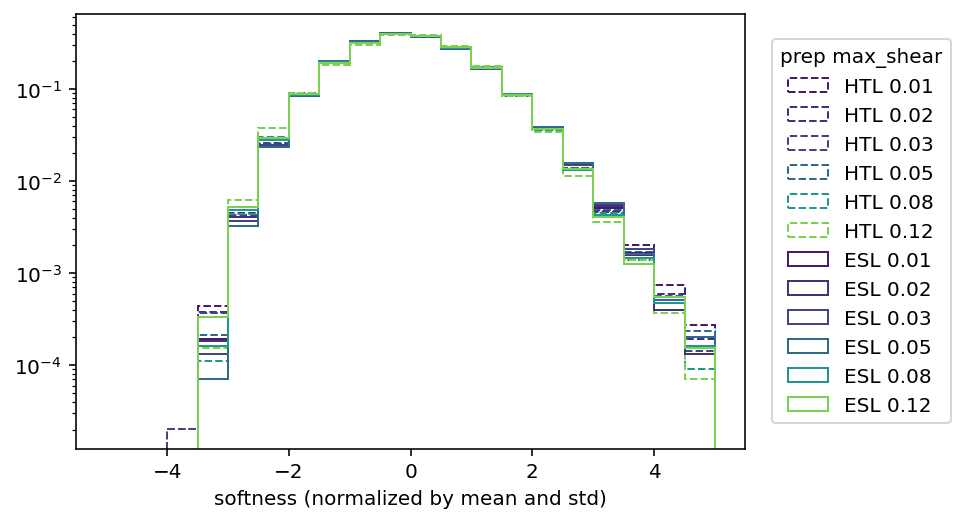

In [26]:
bins = np.linspace(-5, 5, 21)
cmap = cm.get_cmap("viridis")
norm = colors.Normalize(vmin=0.0, vmax=0.15)
for sp, softs in output.items():
    if sp.prep == "ESL":
        ls = "-"
    else:
        ls = "--"
    color = cmap(norm(sp.max_shear))
    softs = np.array(softs)
    softs = softs.reshape(-1)
    plt.hist(softs, bins=bins, density=True, histtype="step", linestyle=ls, label=f"{sp.prep} {sp.max_shear}", color=color)

# legend outside figure to the right
plt.legend(title="prep max_shear", bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.yscale('log')
plt.xlabel("softness (normalized by mean and std)")

/tmp/ipykernel_2128204/3100890987.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("viridis")


Text(0.5, 0, 'softness (normalized by mean and std)')

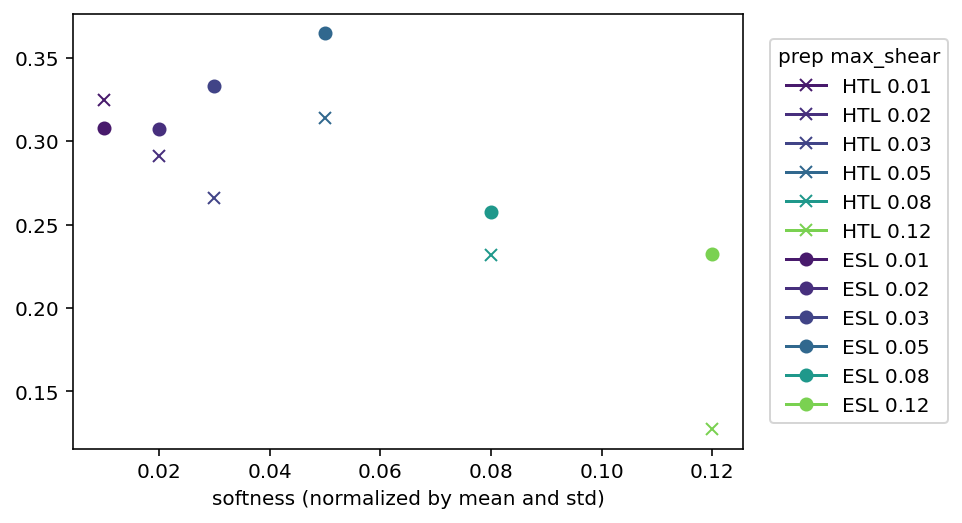

In [30]:
bins = np.linspace(-5, 5, 21)
cmap = cm.get_cmap("viridis")
norm = colors.Normalize(vmin=0.0, vmax=0.15)
for sp, softs in output.items():
    if sp.prep == "ESL":
        ls = "o"
    else:
        ls = "x"
    color = cmap(norm(sp.max_shear))
    softs = np.array(softs)
    softs = softs.reshape(-1)
    # skewness
    skew = stats.skew(softs)
    plt.plot(sp.max_shear, skew, marker=ls, color=color, label=f"{sp.prep} {sp.max_shear}")
    # plt.hist(softs, bins=bins, density=True, histtype="step", linestyle=ls, label=f"{sp.prep} {sp.max_shear}", color=color)

# legend outside figure to the right
plt.legend(title="prep max_shear", bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
# plt.yscale('log')
plt.xlabel("softness (normalized by mean and std)")

In [71]:
vmin = -1
vmax = 1
norm = colors.Normalize(vmin=vmin, vmax=vmax)
# norm = colors.LogNorm(vmin=vmin, vmax=vmax)
mshear = 0.08

In [72]:
output = defaultdict(list)

for job in project:
    print(job)
    prep = job.sp["prep"]
    if prep != "HTL":
        continue
    print(prep)
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/strob-softness_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 5e-3 or float(max_shear) != mshear:
            continue

        if job.isfile(df_path):
            dataset = pl.read_parquet(job.fn(df_path), use_pyarrow=True)
        else:
            continue

        traj = gsd.hoomd.open(exper, "rb")

        for frame, _, soft in dataset.rows()[-1:]:
            frame
            soft = np.array(soft)
            # soft = (soft - soft.mean()) / soft.std()
            snap = traj[frame]
            box = snap.configuration.box

            grid = locality.particle_to_grid_square_cic(
                snap.particles.position[:, :2],
                soft.astype(np.float32),
                box[0],
                160
            )
        
        # output[sp].append(soft)
        break
    break

634e14bc75836df75158fb15f379d8bb
HTL


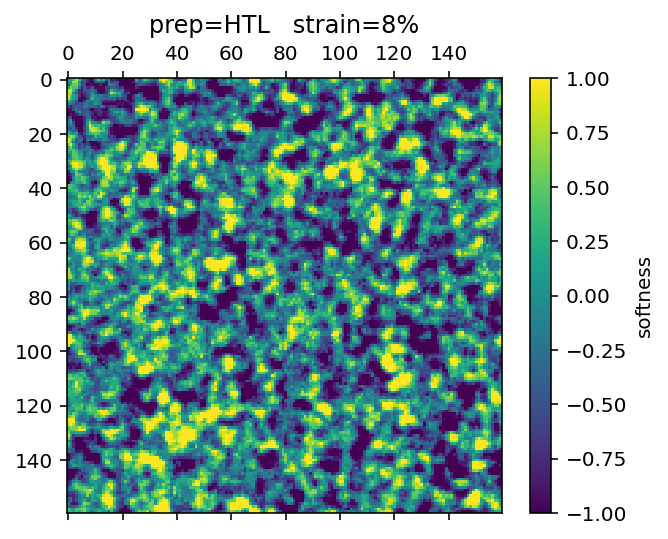

In [73]:
flip = grid.T
s1 = soft
fig, ax = plt.subplots(figsize=(5, 4))
cb = ax.matshow(flip, norm=norm, cmap="viridis")
plt.title(f"prep=HTL   strain={mshear*100:.0f}%")
plt.colorbar(cb, label="softness")

In [74]:
output = defaultdict(list)

for job in project:
    print(job)
    prep = job.sp["prep"]
    if prep != "ESL":
        continue
    print(prep)
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/strob-softness_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 5e-3 or float(max_shear) != mshear: 
            continue

        if job.isfile(df_path):
            dataset = pl.read_parquet(job.fn(df_path), use_pyarrow=True)
        else:
            continue

        traj = gsd.hoomd.open(exper, "rb")

        for frame, _, soft in dataset.rows()[-1:]:
            frame
            soft = np.array(soft)
            # soft = (soft - soft.mean()) / soft.std()
            snap = traj[frame]
            box = snap.configuration.box

            grid = locality.particle_to_grid_square_cic(
                snap.particles.position[:, :2],
                soft.astype(np.float32),
                box[0],
                160
            )
        
        # output[sp].append(soft)
        break
    break

634e14bc75836df75158fb15f379d8bb
7ec2f6aca035e69077eab24383a21cb6
ESL


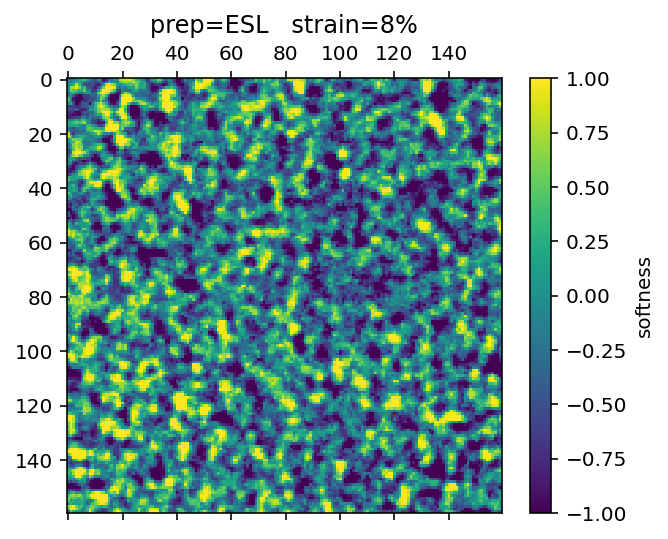

In [75]:
flip = grid.T
s2 = soft
fig, ax = plt.subplots(figsize=(5, 4))
cb = ax.matshow(flip, norm=norm, cmap="viridis")
plt.title(f"prep=ESL   strain={mshear*100:.0f}%")
plt.colorbar(cb, label="softness")

In [91]:
mshear = 0.08

In [92]:
output = defaultdict(list)

for job in project:
    print(job)
    prep = job.sp["prep"]
    if prep != "HTL":
        continue
    print(prep)
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/strob-softness_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 5e-3 or float(max_shear) != mshear:
            continue

        if job.isfile(df_path):
            dataset = pl.read_parquet(job.fn(df_path), use_pyarrow=True)
        else:
            continue

        traj = gsd.hoomd.open(exper, "rb")

        for frame, _, soft in dataset.rows()[-1:]:
            frame
            soft = np.array(soft)
            # soft = (soft - soft.mean()) / soft.std()
            snap = traj[frame]
            box = snap.configuration.box

            grid = locality.particle_to_grid_square_cic(
                snap.particles.position[:, :2],
                soft.astype(np.float32),
                box[0],
                160
            )
        
        # output[sp].append(soft)
        break
    break

634e14bc75836df75158fb15f379d8bb
HTL


/tmp/ipykernel_3314798/2873082158.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  Patch(facecolor=(cm.get_cmap("viridis")(1.0)), label=">0"),
/tmp/ipykernel_3314798/2873082158.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  Patch(facecolor=(cm.get_cmap("viridis")(0.5)), label=">-1 & <0"),
/tmp/ipykernel_3314798/2873082158.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  Patch(facecolor=(cm.get_cmap("viridis")(0.0)), label="<-1")


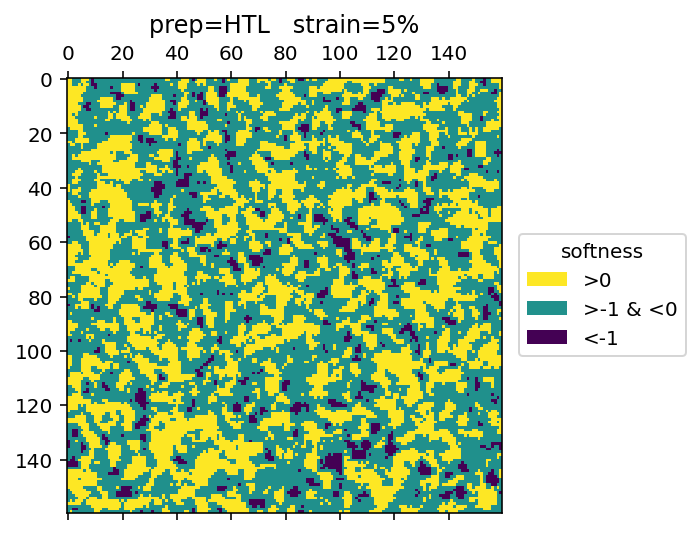

In [93]:
g2 = np.copy(grid)
# g2[grid > 0] = 0.75
# g2[grid > 1] = 1
g2[grid > 0] = 1
g2[grid < -1] = 0
g2[(grid > -1) & (grid < 0)] = 0.5
flip = g2.T
# s2 = soft

# plt.matshow(flip, cmap="viridis")
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(5, 4))
cb = ax.matshow(flip, cmap="viridis")
plt.title(f"prep=HTL   strain={mshear*100:.0f}%")
cs = [
    Patch(facecolor=(cm.get_cmap("viridis")(1.0)), label=">0"),
    Patch(facecolor=(cm.get_cmap("viridis")(0.5)), label=">-1 & <0"),
    Patch(facecolor=(cm.get_cmap("viridis")(0.0)), label="<-1")     
]
plt.legend(handles=cs, title="softness", bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
# plt.colorbar(cb, label="softness")

In [94]:
output = defaultdict(list)

for job in project:
    print(job)
    prep = job.sp["prep"]
    if prep != "ESL":
        continue
    print(prep)
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/strob-softness_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 5e-3 or float(max_shear) != mshear: 
            continue

        if job.isfile(df_path):
            dataset = pl.read_parquet(job.fn(df_path), use_pyarrow=True)
        else:
            continue

        traj = gsd.hoomd.open(exper, "rb")

        for frame, _, soft in dataset.rows()[-1:]:
            frame
            soft = np.array(soft)
            # soft = (soft - soft.mean()) / soft.std()
            snap = traj[frame]
            box = snap.configuration.box

            grid = locality.particle_to_grid_square_cic(
                snap.particles.position[:, :2],
                soft.astype(np.float32),
                box[0],
                160
            )
        
        # output[sp].append(soft)
        break
    break

634e14bc75836df75158fb15f379d8bb
7ec2f6aca035e69077eab24383a21cb6
ESL


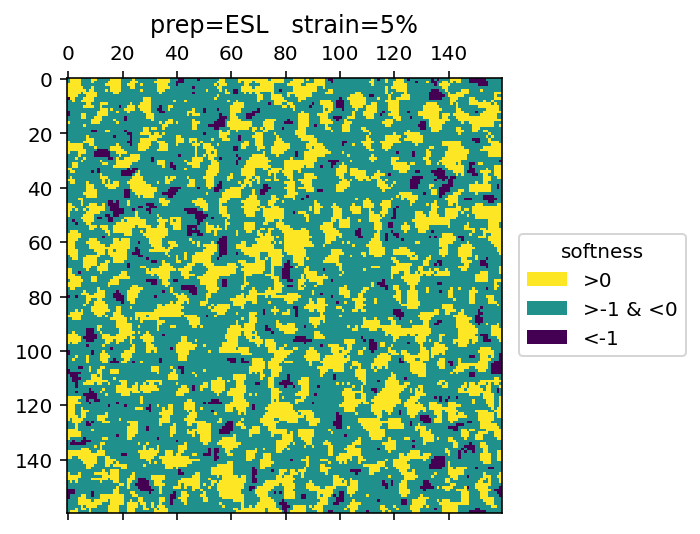

In [95]:
g2 = np.copy(grid)
# g2[grid > 0] = 0.75
g2[grid > 0] = 1
g2[grid < -1] = 0
g2[(grid > -1) & (grid < 0)] = 0.5
flip = g2.T
# s2 = soft

from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(5, 4))
cb = ax.matshow(flip, cmap="viridis")
cmap = plt.colormaps["viridis"]
plt.title(f"prep=ESL   strain={mshear*100:.0f}%")
cs = [
    Patch(facecolor=cmap(1.0), label=">0"),
    Patch(facecolor=cmap(0.5), label=">-1 & <0"),
    Patch(facecolor=cmap(0.0), label="<-1")     
]
plt.legend(handles=cs, title="softness", bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
# plt.colorbar(cb, label="softness")

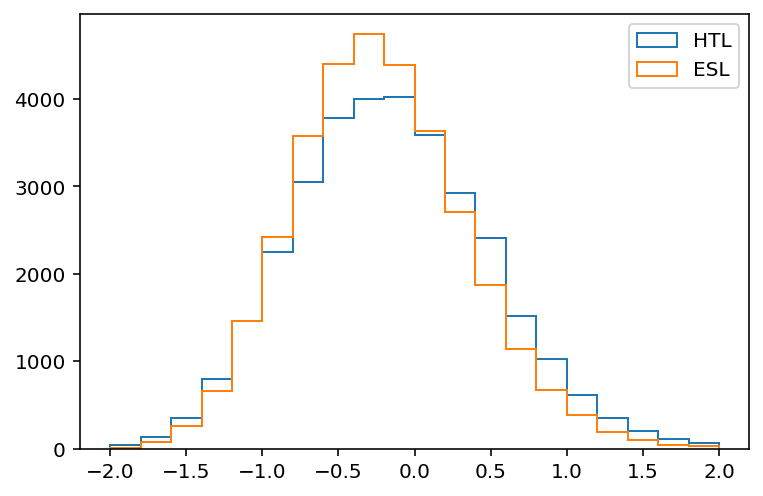

In [313]:
bins = np.linspace(-2, 2, 21)
plt.hist(s1, histtype="step", bins=bins, label="HTL")
plt.hist(s2, histtype="step", bins=bins, label="ESL");
plt.legend()

Text(0.5, 1.0, 'strain=1%')

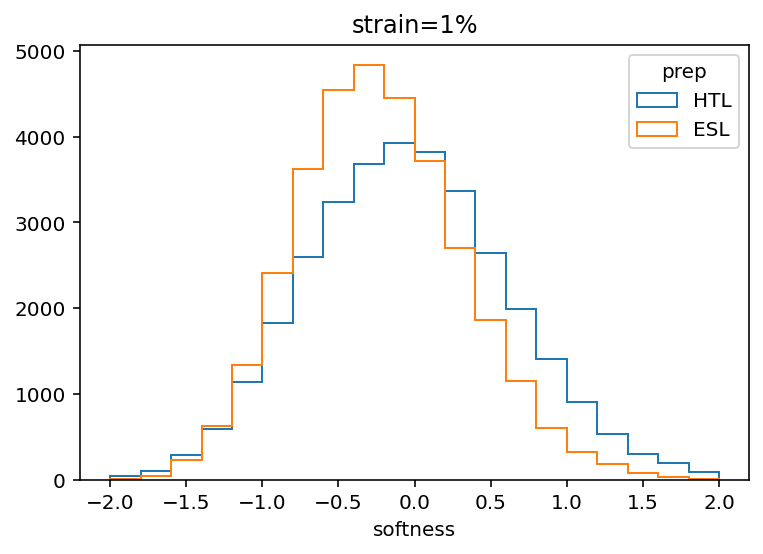

In [45]:
bins = np.linspace(-2, 2, 21)
plt.hist(s1, histtype="step", bins=bins, label="HTL")
plt.hist(s2, histtype="step", bins=bins, label="ESL");
plt.legend(title="prep")
plt.xlabel("softness")
plt.title(f"strain={mshear*100:.0f}%")

In [277]:
out = np.fft.fft2(grid)
abs_out = np.abs(out)
N = grid.shape[0]
freq = np.fft.fftfreq(N)

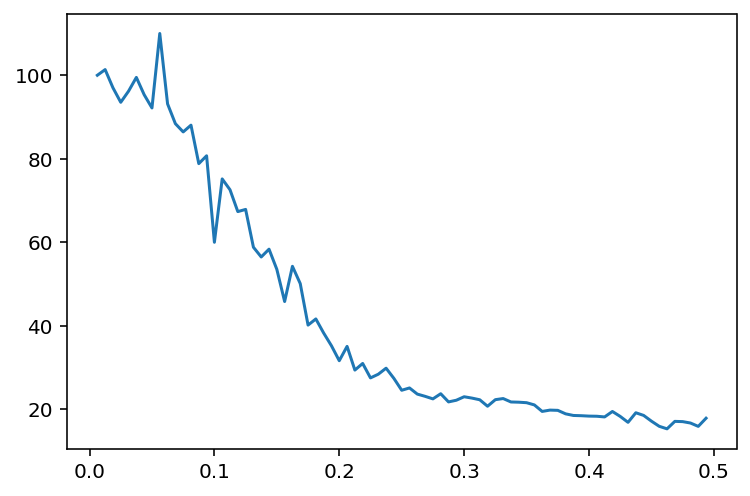

In [278]:
plt.plot(freq[1:N//2], np.mean(abs_out, axis=1)[1:N//2])

In [279]:
out.shape

(160, 160)

In [282]:
soft

array([ 0.56126618, -0.79335737,  0.16974087, ..., -0.35652038,
       -0.61953944,  0.07472324])

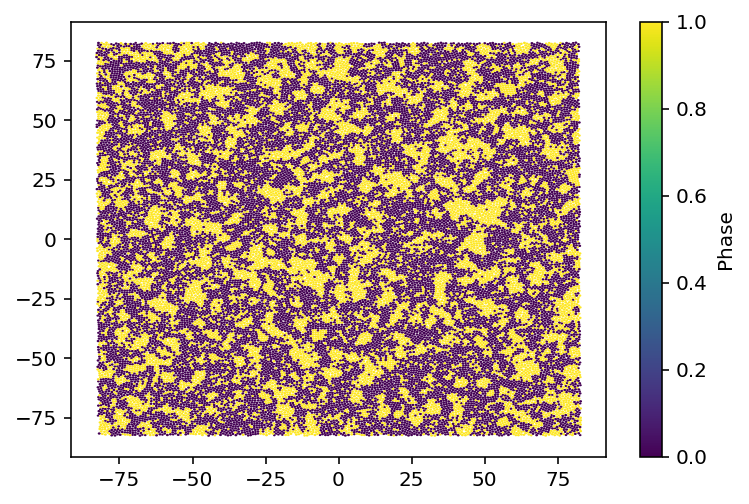

In [283]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle
import matplotlib.pyplot as plt

# extract particle positions and data
positions = snap.particles.position
positions[:,1] = -positions[:,1]
diams = snap.particles.diameter
color_data = np.zeros(len(positions))
# color_data[(soft < 0) & (soft > -1)] = 0
color_data[(soft >= 0) | (soft <= -1)] = 1
# abs_data = np.abs(soft_ffts[:,i])

# create a list of circles with positions and radius
circles = [Circle((x[0], x[1]), radius=d/2.0) for x, d in zip(positions, diams)]

# create a patch collection with circles and color data
# norm = colors.LogNorm(vmax=100)
norm = colors.Normalize()
collection = PatchCollection(circles, cmap='viridis', norm=norm)
collection.set_array(color_data)
# norm2 = colors.Normalize(vmin=np.quantile(abs_data, 0.2), vmax=np.quantile(abs_data, 0.8))
alpha = 1
# clamp between 0 and 1
alpha = np.clip(alpha, 0, 1)
collection.set_alpha(alpha)

# plot particles with color
fig, ax = plt.subplots()
ax.add_collection(collection)
ax.autoscale()

# zoom in 5x
zoom = 1
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim((xlim[0] + xlim[1])/2 - (xlim[1] - xlim[0])/zoom/2, (xlim[0] + xlim[1])/2 + (xlim[1] - xlim[0])/zoom/2)
ax.set_ylim((ylim[0] + ylim[1])/2 - (ylim[1] - ylim[0])/zoom/2, (ylim[0] + ylim[1])/2 + (ylim[1] - ylim[0])/zoom/2)

plt.colorbar(collection, label="Phase")

plt.show()


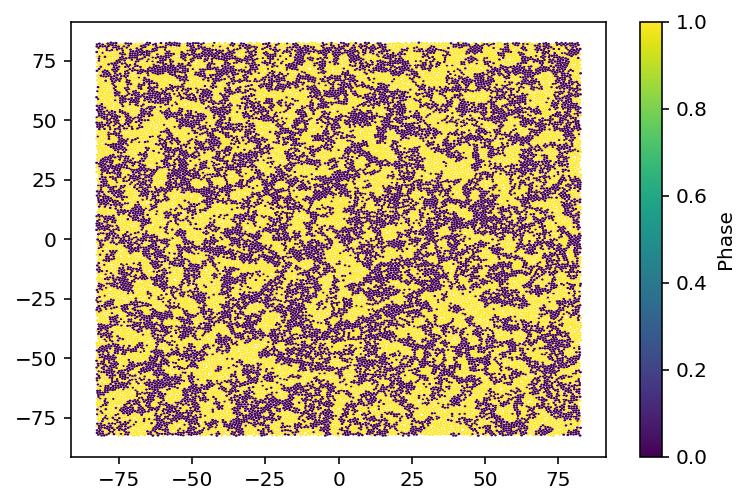

In [285]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle
import matplotlib.pyplot as plt

# extract particle positions and data
positions = snap.particles.position
positions[:,1] = -positions[:,1]
diams = snap.particles.diameter
color_data = np.zeros(len(positions))
# color_data[(soft < 0) & (soft > -1)] = 0
color_data[(soft >= 0) | (soft <= -1)] = 1
# abs_data = np.abs(soft_ffts[:,i])

# create a list of circles with positions and radius
circles = [Circle((x[0], x[1]), radius=d/2.0) for x, d in zip(positions, diams)]

# create a patch collection with circles and color data
# norm = colors.LogNorm(vmax=100)
norm = colors.Normalize()
collection = PatchCollection(circles, cmap='viridis', norm=norm)
collection.set_array(color_data)
# norm2 = colors.Normalize(vmin=np.quantile(abs_data, 0.2), vmax=np.quantile(abs_data, 0.8))
alpha = 1
# clamp between 0 and 1
alpha = np.clip(alpha, 0, 1)
collection.set_alpha(alpha)

# plot particles with color
fig, ax = plt.subplots()
ax.add_collection(collection)
ax.autoscale()

# zoom in 5x
zoom = 1
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim((xlim[0] + xlim[1])/2 - (xlim[1] - xlim[0])/zoom/2, (xlim[0] + xlim[1])/2 + (xlim[1] - xlim[0])/zoom/2)
ax.set_ylim((ylim[0] + ylim[1])/2 - (ylim[1] - ylim[0])/zoom/2, (ylim[0] + ylim[1])/2 + (ylim[1] - ylim[0])/zoom/2)

plt.colorbar(collection, label="Phase")

plt.show()


In [49]:
output = defaultdict(list)

for job in project:
    print(job)
    prep = job.sp["prep"]
    # if prep != "ESL":
    #     continue
    print(prep)
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/strob-softness_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 5e-3:
            continue

        #  or float(max_shear) != mshear

        if job.isfile(df_path):
            dataset = pl.read_parquet(job.fn(df_path), use_pyarrow=True)
        else:
            continue

        traj = gsd.hoomd.open(exper, "rb")

        for frame, _, soft in dataset.rows()[-1:]:
            frame
            soft = np.array(soft)
            # soft = (soft - soft.mean()) / soft.std()
            snap = traj[frame]
            box = snap.configuration.box
            
            
        output[sp].append(soft)
    #     break
    # break

634e14bc75836df75158fb15f379d8bb
HTL
7ec2f6aca035e69077eab24383a21cb6
ESL
cfa1e4c0007fd65d020f809715a6f0b4
HTL
ecce68c50e28a33684826f28780bf6e9
HTL
1d0fe2ba44a6f635f5504dcbcee0ebc9
ESL
1083a2a09eec2c6cf215ebc7a9706cac
HTL
09d3dccc56f1fa9330b57901cd232ab7
ESL
6976a7c10ada4159010403f8027f3ea5
HTL
9158e73b2e4c9fd1a565e1e5d1bc3af5
HTL
c6d7afd0de62bfa16d05da47815227eb
ESL
bf92a185d043ce3ef666e05e427c7e76
ESL
a8f2c249ed85533b56b0729b7ab96d18
ESL


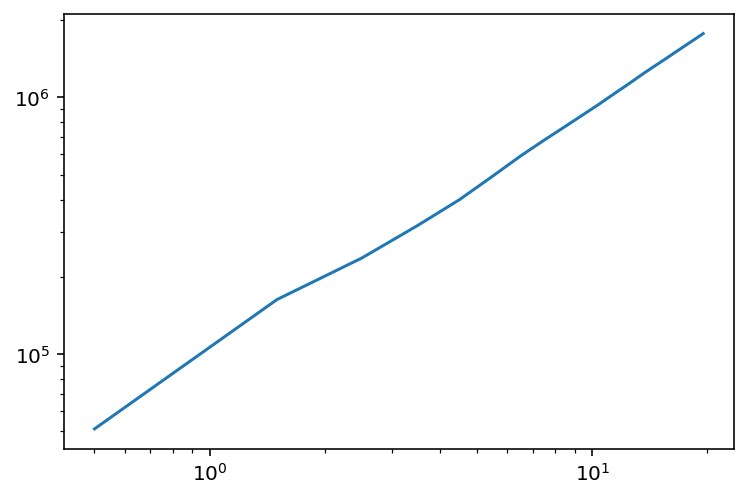

In [48]:
for vmin in [-1]:
    vmax = 0.0
    cond = (soft > vmin) & (soft < vmax)
    npos = snap.particles.position[cond]
    nsoft = soft[cond]
    query = freud.locality.AABBQuery.from_system((box, npos))
    nlist = query.query(npos, dict(r_max=20, exclude_ii=True)).toNeighborList()
    bins = np.linspace(0, 20, 21)
    H, _ = np.histogram(nlist.distances, bins=bins);
    bin_centers = (bins[1:] + bins[:-1]) / 2
    dr = bin_centers[1] - bin_centers[0]
    rmax = bins[-1]
    vol = np.pi * (rmax**2)
    # weight = H.sum()*2.0*np.pi*bin_centers*dr / vol
    H = H 
    plt.plot(bin_centers, H)
plt.xscale('log')
plt.yscale('log')

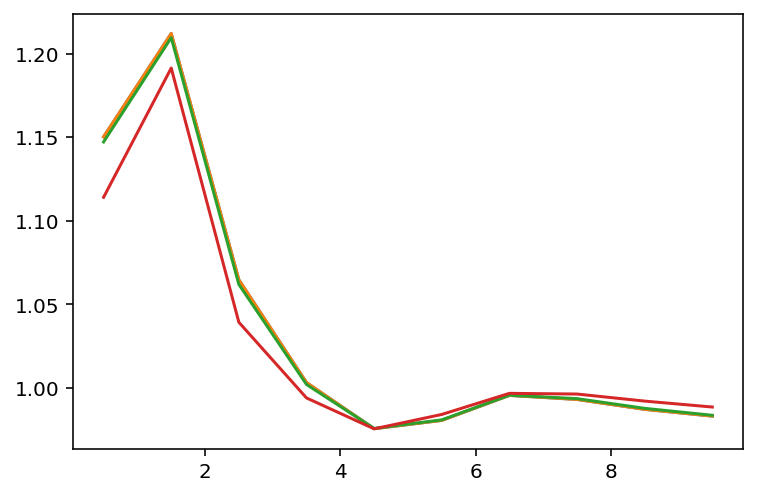

In [257]:
for vmin in [-3, -2, -1.5, -1]:
    vmax = 0
    cond = (soft > vmin) & (soft < vmax)
    npos = snap.particles.position[cond]
    nsoft = soft[cond]
    query = freud.locality.AABBQuery.from_system((box, npos))
    nlist = query.query(npos, dict(r_max=10, exclude_ii=True)).toNeighborList()
    bins = np.linspace(0, 10, 11)
    H, _ = np.histogram(nlist.distances, bins=bins);
    bin_centers = (bins[1:] + bins[:-1]) / 2
    dr = bin_centers[1] - bin_centers[0]
    rmax = bins[-1]
    vol = np.pi * (rmax**2)
    weight = H.sum()*2.0*np.pi*bin_centers*dr / vol
    H = H / (weight)
    plt.plot(bin_centers, H)